In [1]:
#Import libraries to start data exploration/visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Convert total charges from object to float
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

#drop customerID as it does not matter for our analysis 
df = df.drop(columns = 'customerID')

In [5]:
#Start by getting a sense of our data
df.describe()

#We don't have a lot of numeric data. Later on we will need to encode most of our columns for classification

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


C:\Users\charl\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\charl\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


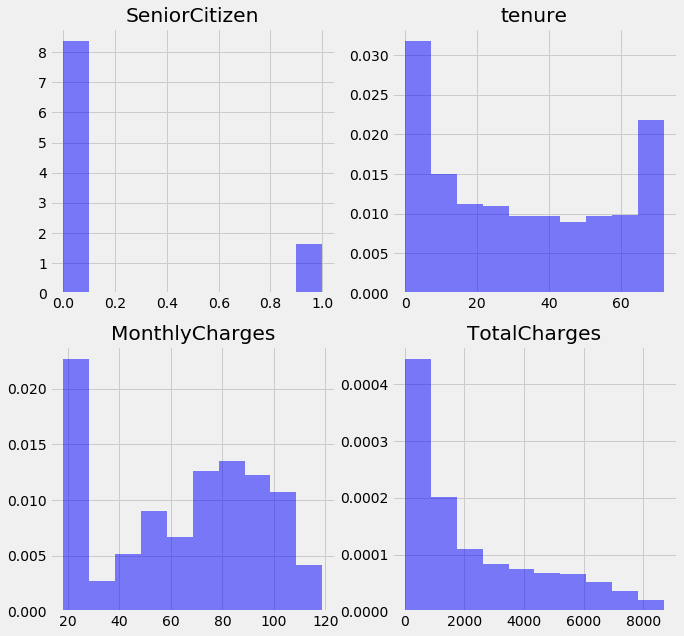

In [6]:
#Create a list of our numeric variables
hists = ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges']

#create figure for our histograms
fig = plt.figure(figsize=(10,10))

for idx, val in enumerate(hists):
    plt.subplot(2,2,idx+1)
    plt.hist(val, data = df, alpha = 0.5, color = 'blue', density=1)
    plt.title(val)
    
#Why aren't these histograms properly normalized? 

In [7]:
#We are lacking numeric data, so let's find our categorical data and get a quick sense of its distribution
#Find all columns that are categorical
cat = df.select_dtypes(include=['object'])
cat.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


C:\Users\charl\anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


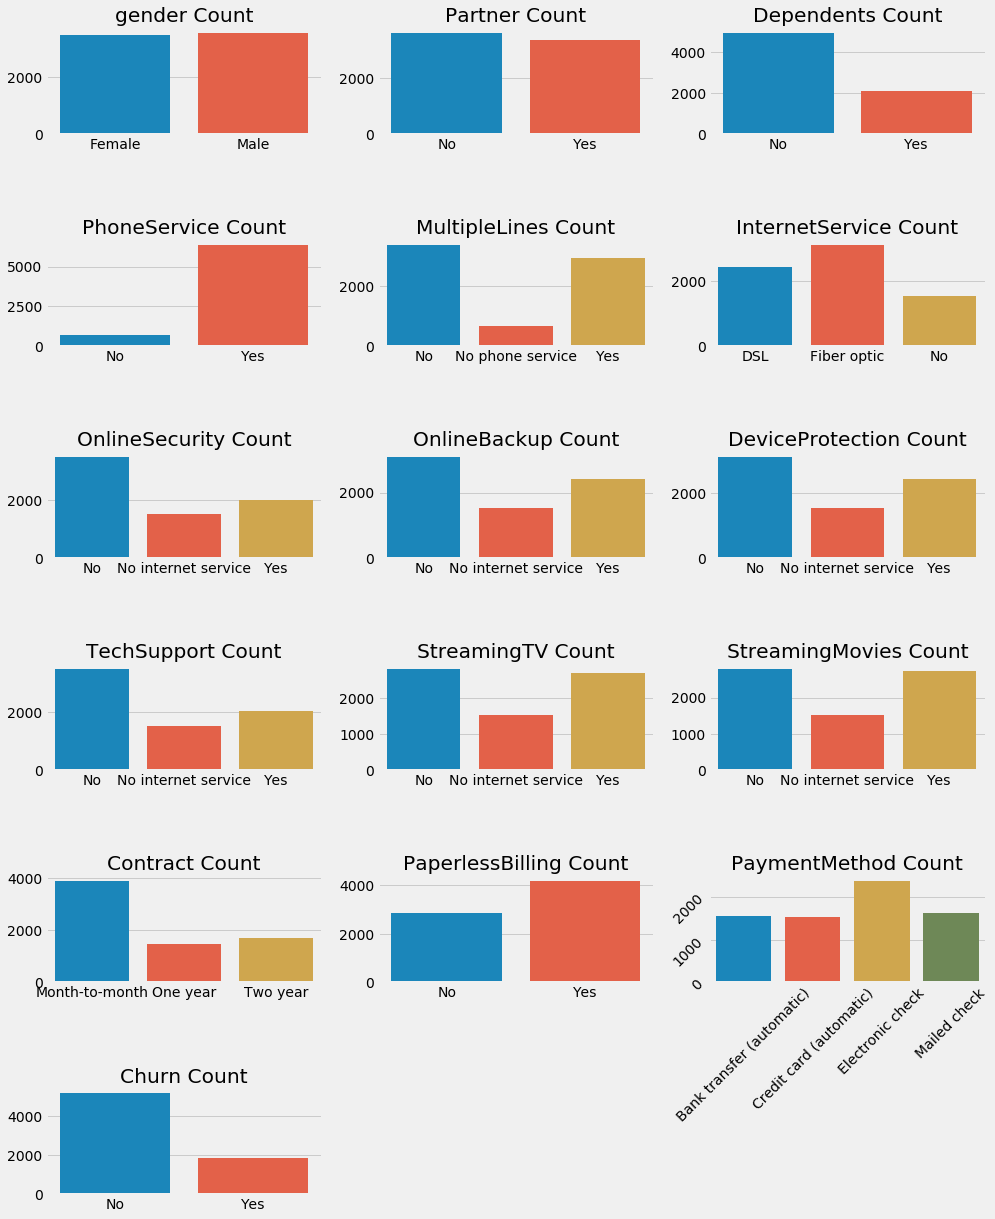

In [8]:
#import math so that we can use ceil function to round our values up for subplotting purposes
import math

#Plot our binary data

fig1 = plt.figure(figsize=(15,20))
for idx, val in enumerate(cat.columns):
    plt.subplot(math.ceil(len(cat.columns)/3),3,idx+1)
    #Sort the values before plotting them... some issues due to names of values...
    #If we really cared, we could change value names so that alphabetically they would appear in desired order
    sns.countplot(x=val, data = df.sort_values(val))
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation = 0)
    plt.title(str(val+' Count'))
    
#Fix vertical spacing and rotate the last subplot as the labels are too long
#In future, need to give unique IDs to each subplot as the below method is incorrect 
plt.subplots_adjust(hspace=1)
plt.subplot(math.ceil(len(cat.columns)/3),3,15).tick_params(labelrotation=45)
#Using barplot and calculating percentage for y axis, we could make these plots more meaningful

In [9]:
#Convert Churn into binary so that we can aggregate it easily. We will do this with all categorical variables later on in our model prep
from sklearn.preprocessing import LabelEncoder
df['Churn'] = LabelEncoder().fit_transform(df['Churn'])

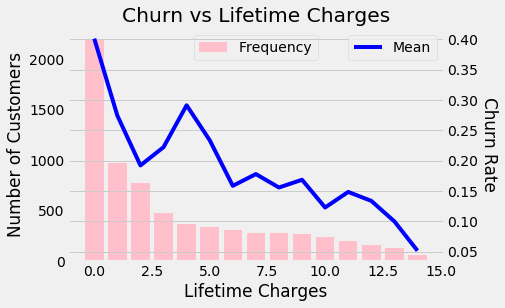

In [10]:
#Break TotalCharges into bins 
a = pd.cut(df['TotalCharges'],bins=15)

#Aggregate Churn rates by these bins
grp = df.groupby(a).Churn.agg(['mean','count']).reset_index()
grp.columns = ['TotalCharges', 'MeanChurn', 'ValueCount']

fig, ax1 = plt.subplots()

#Set up a 2nd axis
ax2 = ax1.twinx()  

ax1.bar(grp.index,grp.ValueCount,label='Frequency',color='pink')
ax2.plot(grp.TotalCharges,grp.MeanChurn,label ='Mean', color = 'blue')

ax1.set_title('Churn vs Lifetime Charges')
ax1.set_ylabel('Number of Customers')
ax2.set_ylabel('Churn Rate',rotation=270,labelpad=20)
ax1.set_xlabel('Lifetime Charges')
ax1.legend(loc=9)
ax2.legend()

#Fix grid lines
ax1.grid(None)

#Need to fix Bins to show dollar amounts, and include percentage on the Yaxis for # Customers

As expected, the longer a customer has been with the telco, the less likely they are to churn.

The majority of our customers are new and at a high risk to churn.

We would see the same results with tenior as Lifetime charges is a proxy for it.

In [11]:
#Find churn percentage
pt_churn = len(df.loc[df.Churn == 1])/len(df)
pt_stay = 1 - pt_churn
print(pt_churn)
print(pt_stay)

0.2653698707936959
0.7346301292063041


Text(0.5, 1.0, 'Likelihood to Churn')

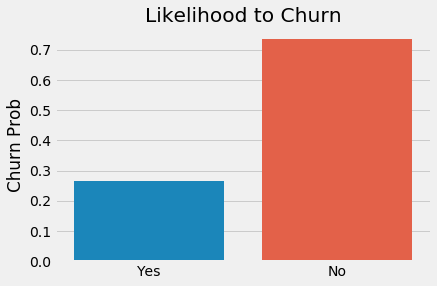

In [12]:
#Graph Churn
fig, ax1 = plt.subplots()
sns.barplot(y = [pt_churn,pt_stay], x = ['Yes','No'])

plt.ylabel('Churn Prob')
plt.title('Likelihood to Churn')

In [13]:
#Analyze if being a senior affects churn. Will visualize this soon
pt_churn_sen = len(df.loc[(df.Churn == 1) & (df.SeniorCitizen == 1)])/len(df)
pt_stay_sen = len(df.loc[(df.Churn == 1) & (df.SeniorCitizen == 0)])/len(df)

pt_churn_nsen = len(df.loc[(df.Churn == 0) & (df.SeniorCitizen == 1)])/len(df)
pt_stay_nsen = len(df.loc[(df.Churn == 0) & (df.SeniorCitizen == 0)])/len(df)


print('Senior Churn:',pt_churn_sen)
print('Senior Retain:',pt_stay_sen)

print('Non-Senior Churn:',pt_churn_nsen)
print('Non-Senior Retain:',pt_stay_nsen)


Senior Churn: 0.06758483600738321
Senior Retain: 0.19778503478631265
Non-Senior Churn: 0.09456197643049837
Non-Senior Retain: 0.6400681527758058


In [14]:
#Let's do some fancier viz factorplots, boxplots, heatmaps, etc

Let's do some modeling!

In [15]:
#Find null values so we can clean up our data
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [16]:
#Luckily, only TotalCharges has null values, and not very many... we could just remove these columns, but let's impute instead
df.TotalCharges = df.TotalCharges.fillna(df.TotalCharges.mean())

In [17]:
#Import libraries to prep our data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#We already have the categorical columns from previous analysis in the df called 'cat'
cat_col = list(cat.columns)

#Encode all categorical variables
for i in cat_col:
    df[i] = LabelEncoder().fit_transform(df[i])

#Define our dependant and independant variables
x = df.drop(columns = 'Churn')
y = df.Churn

#Scale all our features now that they are all numeric
x_scale=StandardScaler().fit_transform(x)


In [18]:
#import models to cross validate so that we can finetune the best performing model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
cross_val_score(LogisticRegression(), x_scale, y).mean()

0.8023577125943608

In [20]:
cross_val_score(SVC(), x_scale, y).mean()

0.8003696811084586

In [21]:
cross_val_score(RandomForestClassifier(), x_scale, y).mean()

0.788019791599458

In [22]:
cross_val_score(DecisionTreeClassifier(), x_scale, y).mean()

0.7258260613587975

In [23]:
cross_val_score(GradientBoostingClassifier(), x_scale, y).mean()

0.804772082069811

In [24]:
cross_val_score(KNeighborsClassifier(), x_scale, y).mean()

0.7536555785857153

GradientBoostingClassifier is the winner! Let's make it better

In [29]:
#import GridSearchCV so we can find best combination of attributes
from sklearn.model_selection import GridSearchCV

#Split data into training and test
x_train, x_test, y_train, y_test = train_test_split(x_scale,y)

#Set paremeters for GridSearchCV, only tuning 2 parameteres as it is already very resource intensive
params = [{'max_depth':list(range(1,4)),'learning_rate':[0.05,0.1,0.15,0.20,0.25,0.3]}]
gbc = GradientBoostingClassifier()
gbc_cv = GridSearchCV(GradientBoostingClassifier(),params)
gbc_cv.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [31]:
print(gbc_cv.best_params_)

{'learning_rate': 0.25, 'max_depth': 1}


In [32]:
print('Our model accuracy is:',gbc_cv.score(x_test,y_test))


Our model accuracy is: 0.7984099943214082


~80% accuracy! Not bad :) 

Now let's further refine our model by dropping insignificant features

Normally, we would do this before choosing and tuning an algorithm, but it is interesting to see how removing features can improve results

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

In [34]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

#As we saw in our previous visualization, TotalCharges is a very strong predictor of churn

               Specs          Score
18      TotalCharges  629275.029414
4             tenure   16278.923685
17    MonthlyCharges    3680.787699
14          Contract    1115.780167
8     OnlineSecurity     551.611529
11       TechSupport     523.303866
9       OnlineBackup     230.086520
10  DeviceProtection     191.303140
1      SeniorCitizen     134.351545
3         Dependents     133.036443


In [35]:
cols1 = featureScores.nlargest(10,'Score').Specs
#Get significant column names in a list so we can easily filter df
cols1 = [i for i in cols1]

#new x values only contain top 10 best features 
x1 = df[cols1]
y1 = df.Churn

x1_scale=StandardScaler().fit_transform(x1)

x1_train, x1_test, y1_train, y1_test = train_test_split(x1_scale,y1)

In [36]:
#Train model with same paramaters as before

gbc1 = GridSearchCV(GradientBoostingClassifier(),params)
gbc1.fit(x1_train,y1_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [37]:
print(gbc1.best_estimator_)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [38]:
print('Our model accuracy is:',gbc1.score(x1_test,y1_test))

Our model accuracy is: 0.80465644520159


Model accuracy improved by ~1% by removing noisy features

Let's further analyze our model results

In [39]:
from sklearn.metrics import classification_report, confusion_matrix


y1_pred = gbc1.predict(x1_test)

cfn_matrix = confusion_matrix(y1_test, y1_pred, labels = [0,1])
cfn_report = classification_report(y1_test, y1_pred)


              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1291
           1       0.68      0.51      0.58       470

    accuracy                           0.80      1761
   macro avg       0.76      0.71      0.73      1761
weighted avg       0.79      0.80      0.80      1761



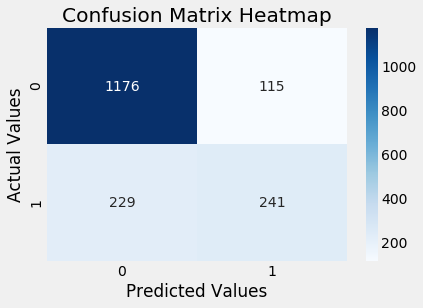

In [46]:
sns.heatmap(cfn_matrix, annot=True, fmt = 'd', cmap="Blues").set_title('Confusion Matrix Heatmap')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
print(cfn_report)

In [49]:
tn, fp, fn, tp = cfn_matrix.ravel()
(tn, fp, fn, tp)

(1176, 115, 229, 241)

In [50]:
from sklearn.metrics import log_loss
y1_prob = gbc1.predict_proba(x1_test)

log_loss(y1_test, y1_prob)

0.4010792443028479